In [5]:
from IPython.display import display, HTML
from pathlib import Path
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_columns', None)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
plt.style.use('ggplot')

%tensorflow_version 2.x
import tensorflow
from tensorflow import keras

print('Available GPU:')
!nvidia-smi -L
print('\nTensorFlow use GPU at: {}'.format(tensorflow.test.gpu_device_name()))

Available GPU:
GPU 0: Tesla T4 (UUID: GPU-eef78b23-6896-359a-e6a9-2025dbfcc8b7)

TensorFlow use GPU at: /device:GPU:0


In [13]:
from google.colab import drive
from pathlib import Path

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.mount(str(drive_path))

Mounted at /content/drive


## Dataset loading and exploration

In [14]:
dataset_df = pd.read_csv("https://raw.githubusercontent.com/ArthurFDLR/OpenHand-App/master/Dataset/OpenHand_dataset.csv")
display(dataset_df)

,label,hand,accuracy,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17,x18,y18,x19,y19,x20,y20
0,0,left,15.139381,0.403383,-0.366229,0.194999,-0.361383,-0.013385,-0.264461,-0.149077,-0.162692,-0.216922,-0.060923,0.083538,-0.002769,-0.027923,0.195922,-0.173307,0.094153,-0.207230,0.002077,0.136845,0.036000,-0.042462,0.200768,-0.153923,0.079615,-0.178153,-0.027000,0.199845,0.045692,0.010846,0.195922,-0.095769,0.079615,-0.120000,-0.012462,0.257999,0.040846,0.131999,0.137769,0.015692,0.113538,-0.057000,0.036000
1,0,left,14.065027,0.333266,-0.430984,0.169325,-0.368800,0.016691,-0.255737,-0.152903,-0.142674,-0.226394,-0.040918,0.186284,-0.006999,0.022344,0.106063,-0.113331,0.100410,-0.124638,0.043879,0.231509,0.049532,-0.005922,0.145635,-0.135944,0.094757,-0.203782,0.004307,0.208897,0.038226,0.016691,0.168248,-0.118985,0.111716,-0.147250,0.038226,0.191937,0.004307,0.027997,0.151288,-0.062453,0.128676,-0.113331,0.060838
2,0,left,13.842453,0.350595,-0.445250,0.176441,-0.385197,0.014298,-0.259086,-0.153850,-0.156995,-0.231919,-0.042895,0.182446,-0.012868,0.026309,0.119248,-0.105808,0.101232,-0.141839,0.035174,0.218479,0.035174,0.014298,0.149275,-0.129829,0.089222,-0.195887,-0.000858,0.212473,0.041179,0.020304,0.173296,-0.117818,0.131259,-0.135834,0.041179,0.188452,0.029169,0.026309,0.173296,-0.081786,0.137264,-0.135834,0.047185
3,0,left,13.833808,0.385959,-0.439295,0.199288,-0.379078,0.018638,-0.252623,-0.137925,-0.156277,-0.246315,-0.053908,0.175201,-0.011757,0.012616,0.090612,-0.095774,0.108677,-0.174055,0.030395,0.211331,0.036417,0.006595,0.138785,-0.137925,0.090612,-0.204164,0.000287,0.211331,0.042438,0.018638,0.174915,-0.119860,0.132763,-0.149969,0.036417,0.199288,0.042438,0.036703,0.180937,-0.077708,0.138785,-0.131904,0.048460
4,0,left,14.223233,0.394632,-0.452991,0.209146,-0.399995,0.017034,-0.280753,-0.155203,-0.174761,-0.254571,-0.022397,0.169398,-0.022397,0.003785,0.057097,-0.148579,0.076971,-0.155203,0.023975,0.215770,0.023975,-0.029337,0.136591,-0.148579,0.090220,-0.201575,0.023975,0.222395,0.043848,0.017034,0.182963,-0.128705,0.136591,-0.135330,0.063722,0.222395,0.063722,0.056781,0.189588,-0.049211,0.169714,-0.122081,0.070346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11199,Ok,right,16.390480,-0.268922,-0.482060,-0.075778,-0.414880,0.100571,-0.351898,0.230733,-0.309910,0.302113,-0.242730,0.029192,-0.078977,0.180348,-0.036989,0.260125,-0.112567,0.272721,-0.225934,-0.054784,-0.028592,0.037589,0.189745,0.104770,0.307311,0.167752,0.416479,-0.130362,-0.032790,-0.121965,0.164552,-0.071579,0.307311,-0.042188,0.420678,-0.201741,-0.074778,-0.243729,0.088974,-0.239530,0.198143,-0.235332,0.298913
11200,Ok,right,16.541039,-0.262293,-0.479240,-0.077709,-0.412118,0.090095,-0.361777,0.224338,-0.311436,0.295654,-0.240119,0.022973,-0.080706,0.186582,-0.034560,0.257899,-0.118461,0.283069,-0.235924,-0.048343,-0.030364,0.039754,0.183585,0.119460,0.305243,0.182387,0.414316,-0.128050,-0.030364,-0.115465,0.171000,-0.077709,0.305243,-0.044148,0.418511,-0.211952,-0.068120,-0.249708,0.099684,-0.245513,0.200366,-0.241318,0.305243
11201,Ok,right,16.726860,-0.248505,-0.488085,-0.077744,-0.413117,0.093016,-0.350644,0.217963,-0.313160,0.288766,-0.246522,0.022213,-0.079926,0.184644,-0.042442,0.255447,-0.121575,0.276271,-0.246522,-0.044425,-0.021618,0.047202,0.182462,0.122170,0.307409,0.184644,0.411531,-0.127723,-0.021618,-0.115228,0.178297,-0.077744,0.307409,-0.044425,0.419861,-0.211021,-0.071596,-0.252670,0.094999,-0.248505,0.207451,-0.244340,0.307409
11202,Ok,right,16.430834,-0.262744,-0.477646,-0.070791,-0.408216,0.100741,-0.355123,0.215096,-0.314281,0.268190,-0.253020,0.031312,-0.085572,0.190592,-0.048815,0.255937,-0.126413,0.255937,-0.244852,-0.038118,-0.020226,0.059900,0.179895,0.137498,0.306502,0.198760,0.408605,-0.132053,-0.024310,-0.11

In [28]:
hand_label = 'right'
test_split = 0.10

# Selection right hand samples and group by label
dataset_groups = dataset_df.loc[dataset_df['hand'] == hand_label].groupby('label')
# Find the minimum number of samples accross categories to uniformly distributed sample sets
total_size_cat = dataset_groups.size().min()
test_size_cat  = int(total_size_cat*test_split)
train_size_cat = total_size_cat - test_size_cat

labels = []
x_train = []
x_test = []
y_train = []
y_test = []

# Iterate over each labeled group
for label, group in dataset_groups:
    labels.append(label)
    # remove irrelevant columns
    group_array = group.drop(['label', 'hand', 'accuracy'], axis=1).to_numpy()
    np.random.shuffle(group_array)
    
    x_train.append(group_array[:train_size_cat])
    y_train.append([label]*train_size_cat)
    x_test.append(group_array[train_size_cat : train_size_cat+test_size_cat])
    y_test.append([label]*test_size_cat)

# Concatenate sample sets as numpy arrays and shuffle in unison
shuffler_test = np.random.permutation(len(y_test))
shuffler_train = np.random.permutation(len(y_train))
x_train = np.concatenate(x_train, axis=0)[shuffler_train]
x_test = np.concatenate(x_test, axis=0)[shuffler_test]
y_train = np.concatenate(y_train, axis=0)[shuffler_train]
y_test = np.concatenate(y_test, axis=0)[shuffler_test]

# One-hot encoding
y_train_onehot = keras.utils.to_categorical([labels.index(sample) for sample in y_train])
y_test_onehot = keras.utils.to_categorical([labels.index(sample) for sample in y_test])

# Display dataset informations
display(pd.DataFrame(dataset_groups.size(), columns=['Nbr of samples ({} hand)'.format(hand_label)]).transpose())
display(HTML('''There are {n_cat} categories with a minimum of {min} samples for the {hand} hand.
                Given a training/test split ratio of {split}% on uniformly distributed sets,
                the training set has {n_train} samples and the test set has {n_test} samples:'''
             .format(hand=hand_label, n_cat=len(labels), min=total_size_cat, split=test_split*100, n_train=x_train.shape[0], n_test=x_test.shape[0])))
display(pd.DataFrame([str(d.shape) for d in (x_train, x_test, y_train, y_test)],
                     index = ['x_train', 'x_test', 'y_train', 'y_test'],
                     columns = ['shape']))

label,0,1,2,3,4,5,6,7,8,9,Chef,Dislike,FightFist,Help,Horns,Loser,Metal,MiddleFinger,Ok,Phone,PowerFist,Shaka,Spoke,Stop,Super,VIP,Water
Nbr of samples (right hand),208,207,203,205,213,206,202,202,205,209,206,206,203,209,207,205,214,201,208,204,211,208,206,204,208,221,204


,shape
x_train,"(27, 42)"
x_test,"(27, 42)"
y_train,"(27,)"
y_test,"(27,)"


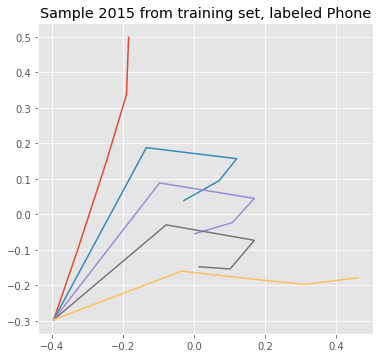

In [17]:
colors = ["r", "y", "g", "b", "m"]
sample_index = np.random.randint(x_train.shape[0])
sample_data = x_train[sample_index]
sample_data_2D = np.stack([sample_data[::2], sample_data[1::2]])

sample_fingers = [
    sample_data_2D[:, 0:5],
    np.insert(sample_data_2D[:, 5:9].T, 0, sample_data_2D[:, 0], axis=0).T,
    np.insert(sample_data_2D[:, 9:13].T, 0, sample_data_2D[:, 0], axis=0).T,
    np.insert(sample_data_2D[:, 13:17].T, 0, sample_data_2D[:, 0], axis=0).T,
    np.insert(sample_data_2D[:, 17:21].T, 0, sample_data_2D[:, 0], axis=0).T,
]

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Sample {} from training set, labeled {}'.format(sample_index, y_train[sample_index]))
ax.set_aspect("equal")
for finger, c in zip(sample_fingers, colors):
    ax.plot(finger[0], finger[1])

## Models exploration

In [9]:
model_train_history = {}
input_dim = x_train.shape[1]
validation_split = 0.20
epochs = 15

In [10]:
model = keras.models.Sequential(name = 'ANN-3x16',
                                   layers =
    [
        keras.layers.Input(shape=input_dim),
        keras.layers.Dense(16, activation=keras.activations.relu),
        keras.layers.Dense(16, activation=keras.activations.relu),
        keras.layers.Dense(16, activation=keras.activations.relu),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    #callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, min_lr=0.001)],
)

Model: "ANN-3x16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                688       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 27)                459       
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
978/978 [==============================] - 5s 3ms/step - loss: 2.6384 - accuracy: 0.2296 - val_loss: 0.7669 - val_accuracy: 0.7587
Epoch 2/15
978/978 [==============================] - 3s 3ms/step - loss: 0.5800 - accuracy: 0.8482 - val_loss: 

In [ ]:
model = keras.models.Sequential(name = 'ANN-3x64',
                                   layers =
    [
        keras.layers.Input(shape=input_dim),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, min_lr=0.001)],
)

Model: "ANN-3x64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                2752      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 27)                1755      
Total params: 12,827
Trainable params: 12,827
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
978/978 [==============================] - 3s 3ms/step - loss: 0.7197 - accuracy: 0.8263 - val_loss: 0.1095 - val_accuracy: 0.9622
Epoch 2/15
978/978 [==============================] - 3s 3ms/step - loss: 0.0452 - accuracy: 0.9875 - val_loss

In [ ]:
model = keras.models.Sequential(name = 'ANN-3x64-Dropouts',
                                   layers =
    [
        keras.layers.Input(shape=input_dim),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, min_lr=0.001)],
)

Model: "ANN-3x64-Dropouts"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                2752      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 27)          

In [ ]:
model = keras.models.Sequential(name = 'ANN-2x128',
                                   layers =
    [
        keras.layers.Input(shape=input_dim),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
)

Model: "ANN-2x128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               5504      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 27)                3483      
Total params: 25,499
Trainable params: 25,499
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
978/978 [==============================] - 3s 3ms/step - loss: 0.6274 - accuracy: 0.8570 - val_loss: 0.0619 - val_accuracy: 0.9847
Epoch 2/15
978/978 [==============================] - 3s 3ms/step - loss: 0.0407 - accuracy: 0.9898 - val_loss: 0.0475 - val_accuracy: 0.9867
Epoch 3/15
978/978 [==============================] - 3s 3ms/step - loss: 0.0206 - accuracy: 0.9944

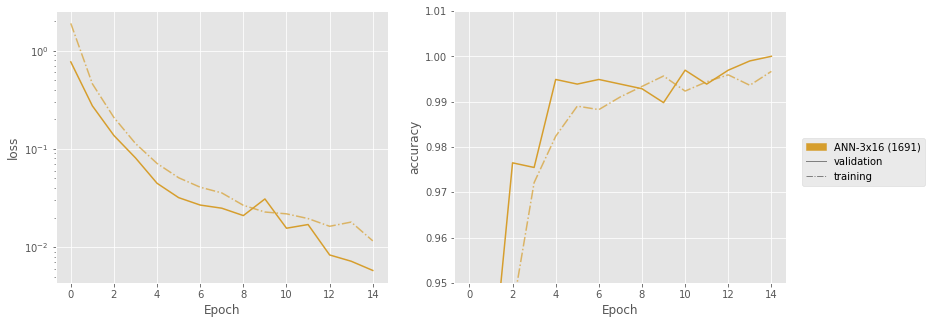

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
colors_graph = ["#d69e2d",
                "#927ced",
                "#73bd4d",
                "#e462c0",
                "#eb5e52"]
handles = []

for (model, history), color in zip(model_train_history.items(), colors_graph):
    label = '{} ({})'.format(model.name, model.count_params())
    axs[0].plot(history.history['loss'], c=color, ls='-.', alpha=.7)
    axs[1].plot(history.history['accuracy'], c=color, ls='-.', alpha=.7)
    axs[0].plot(history.history['val_loss'], c=color)
    axs[1].plot(history.history['val_accuracy'], c=color)
    handles.append(mpatches.Patch(color=color, label=label))

for ax in axs:
    ax.set_xlabel('Epoch')
axs[0].set_ylabel('loss')
axs[0].set_yscale('log')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0.95,1.01)

handles.append(Line2D([0], [0], color='grey', lw=1, ls='-', label='validation'))
handles.append(Line2D([0], [0], color='grey', lw=1, ls='-.', label='training'))

fig.subplots_adjust(right=0.85)
fig.legend(handles=handles,
           loc="center right",
           borderaxespad=1)

## Final model training and save

In [25]:
model = keras.models.Sequential(name = '27Class_3x64',
                                   layers =
    [
        keras.layers.Input(shape=input_dim),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

save_path = drive_path / 'My Drive'
for subfolder in ['OpenHand', 'Models', model.name]:
    save_path /= subfolder
    if not (save_path).is_dir():
        %mkdir {save_path}
    

model_path = save_path / '{name}_{hand}.h5'.format(name = model.name, hand = hand_label)

model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=1,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    callbacks=[keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)],
    verbose = 2,
)

class_file = open(save_path / 'class.txt', 'w')
for i, label_i in enumerate(labels):
    class_file.write((',' if i!=0 else '') + label_i)
class_file.close()

Model: "p"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                2752      
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 27)                1755      
Total params: 12,827
Trainable params: 12,827
Non-trainable params: 0
_________________________________________________________________
/content/drive/My Drive
/content/drive/My Drive/OpenHand
/content/drive/My Drive/OpenHand/Models
mkdir: cannot create directory ‘/content/drive/My’: Operation not supported
mkdir: cannot create directory ‘Drive/OpenHand/Models/p’: No such file or directory
97

In [26]:
model_test = keras.models.load_model(model_path)
model_test.evaluate(x=x_test, y=y_test_onehot)

17/17 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9852


[0.07547415792942047, 0.9851852059364319]